In [1]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM

2024-12-07 23:29:23.355045: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733642963.369370   72391 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733642963.373727   72391 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-07 23:29:23.388930: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import os
import pandas as pd
import numpy as np

# Directory containing the CSV files
directory = '../processed-final-data'

# Dictionary to store the dataframes
dataframes = {}

# Iterate over all files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Extract the file name without extension and convert it to int
        key = int(os.path.splitext(filename)[0])
        
        # Read the CSV file into a dataframe
        df = pd.read_csv(os.path.join(directory, filename))
        dataframes[key] = df


# Print the dictionary keys to verify
print(dataframes.keys())

dict_keys([72790024141, 72785524114, 72789094197, 72793024233, 72785794129, 72788594266, 72797624217, 72785024157, 72797094240, 72798594276, 72792424223, 72792894263, 72781024243, 72781524237, 72788324220, 72698824219, 72793894274, 74206024207, 72782724110, 72793724222, 72792594227, 72782594239, 72794504205, 72792394225, 72784524163, 72792024227, 72785694176])


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from torch_geometric.nn.norm import BatchNorm

class GNNWithEdgeFeature(torch.nn.Module):
    def __init__(self, in_channels, edge_in_channels, hidden_channels, out_channels, lstm_hidden_size, lstm_num_layers):
        super(GNNWithEdgeFeature, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=4, concat=False)  # GAT layer
        self.edge_mlp = torch.nn.Linear(edge_in_channels, hidden_channels)
        self.batch_norm1 = BatchNorm(hidden_channels)
        self.batch_norm2 = BatchNorm(hidden_channels)
        self.batch_norm3 = BatchNorm(hidden_channels)
        self.dropout = torch.nn.Dropout(p=0.5)
        
        # LSTM layers
        self.lstm1 = torch.nn.LSTM(hidden_channels, lstm_hidden_size, lstm_num_layers, batch_first=True)
        self.output_layer = torch.nn.Linear(lstm_hidden_size, out_channels)

    def forward(self, x, edge_index, edge_attr):
        # Apply the edge MLP to the edge features
        edge_features = self.edge_mlp(edge_attr)
        
        # Compute inverse distance weights
        edge_weights = 1.0 / (edge_attr + 1e-6)  # Adding a small value to avoid division by zero
        
        # Apply the first GCN convolution with edge weights
        x = self.conv1(x, edge_index, edge_weight=edge_weights)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Apply the second GAT convolution
        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)
        
        # Prepare data for LSTM
        x = x.view(1, -1, x.size(1))  # Add batch dimension and reshape
        
        # Apply the first LSTM layer
        x, _ = self.lstm1(x)
        
        # Remove batch dimension and reshape
        x = x.view(-1, x.size(2))
        
        # Apply the output layer
        x = self.output_layer(x)
        
        return x

In [4]:
for key, df in dataframes.items():
    print(f"DataFrame with key {key} has {df.shape[1]} columns.")

DataFrame with key 72790024141 has 59 columns.
DataFrame with key 72785524114 has 59 columns.
DataFrame with key 72789094197 has 59 columns.
DataFrame with key 72793024233 has 59 columns.
DataFrame with key 72785794129 has 59 columns.
DataFrame with key 72788594266 has 59 columns.
DataFrame with key 72797624217 has 59 columns.
DataFrame with key 72785024157 has 59 columns.
DataFrame with key 72797094240 has 59 columns.
DataFrame with key 72798594276 has 59 columns.
DataFrame with key 72792424223 has 59 columns.
DataFrame with key 72792894263 has 59 columns.
DataFrame with key 72781024243 has 59 columns.
DataFrame with key 72781524237 has 59 columns.
DataFrame with key 72788324220 has 59 columns.
DataFrame with key 72698824219 has 59 columns.
DataFrame with key 72793894274 has 59 columns.
DataFrame with key 74206024207 has 59 columns.
DataFrame with key 72782724110 has 59 columns.
DataFrame with key 72793724222 has 59 columns.
DataFrame with key 72792594227 has 59 columns.
DataFrame wit

In [5]:
# Check for null values in each dataframe
for key, df in dataframes.items():
    null_values = df.isnull().sum()
    print(f"DataFrame with key {key} null values:\n{null_values}\n")

DataFrame with key 72790024141 null values:
DailyWindDirection          0
DailyDewPointTemperature    0
DailyStationPressure        0
DailyWindSpeed              0
DailyPressureTendency       0
DailyAltimeterSetting       0
DailyWetBulbTemperature     0
DailyDryBulbTemperature     0
DailySeaLevelPressure       0
DailyRelativeHumidity       0
DailyPressureChange         0
DailyPrecipitation          0
AW_FG                       0
AW_*                        0
AU_FG:2                     0
AU_FZ:8                     0
AW_RA                       0
AU_-DZ:01                   0
AU_+RA:02                   0
AU_VCFG:2                   0
AU_+SN:03                   0
AW_HAIL                     0
AW_SQ                       0
AU_-RA:02                   0
MW_FG                       0
AW_HZ                       0
AU_FU:3                     0
MW_SH                       0
AU_-GS:08                   0
AU_BC:3                     0
AU_-FZ:8                    0
AU_DU:5                   

In [6]:
# Drop any dataframe with null values
dataframes = {key: df for key, df in dataframes.items() if not df.isnull().values.any()}

# Print the keys of the remaining dataframes to verify
print(dataframes.keys())

dict_keys([72790024141, 72785524114, 72789094197, 72793024233, 72785794129, 72788594266, 72797624217, 72785024157, 72797094240, 72798594276, 72792424223, 72792894263, 72781024243, 72781524237, 72788324220, 72698824219, 72793894274, 74206024207, 72782724110, 72793724222, 72792594227, 72782594239, 72794504205, 72792394225, 72784524163, 72792024227, 72785694176])


In [7]:
num_nodes = len(dataframes)
print(f"Number of nodes: {num_nodes}")
# Calculate the number of edges if every node is connected to every other node
num_edges = num_nodes * (num_nodes - 1) // 2
print(f"Number of edges: {num_edges}")

Number of nodes: 27
Number of edges: 351


In [8]:
import itertools
import torch

# Generate all possible pairs of nodes
edge_index = torch.tensor(list(itertools.combinations(range(num_nodes), 2)), dtype=torch.long).t()

print(edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
          2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
          3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,
          5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,
          6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,
          7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10,
         10, 10, 10, 10, 10,

In [9]:
# Dictionary to store the split dataframes
split_dataframes = {}

for key, df in dataframes.items():
    # Calculate the split index
    split_index = int(len(df) * 0.8)
    
    # Split the dataframe
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]
    
    # Store the split dataframes in the dictionary
    split_dataframes[key] = {'train': train_df, 'test': test_df}

# Print the keys of the split dataframes to verify
print(split_dataframes.keys())

dict_keys([72790024141, 72785524114, 72789094197, 72793024233, 72785794129, 72788594266, 72797624217, 72785024157, 72797094240, 72798594276, 72792424223, 72792894263, 72781024243, 72781524237, 72788324220, 72698824219, 72793894274, 74206024207, 72782724110, 72793724222, 72792594227, 72782594239, 72794504205, 72792394225, 72784524163, 72792024227, 72785694176])


In [10]:
# Dictionary to store the train dataframes for each node
node_train_dataframes = {}

# Iterate over the split_dataframes and assign the train_df to each node
for key, split_df in split_dataframes.items():
    node_train_dataframes[key] = split_df['train']

# Print the keys of the node_train_dataframes to verify
print(node_train_dataframes.keys())

dict_keys([72790024141, 72785524114, 72789094197, 72793024233, 72785794129, 72788594266, 72797624217, 72785024157, 72797094240, 72798594276, 72792424223, 72792894263, 72781024243, 72781524237, 72788324220, 72698824219, 72793894274, 74206024207, 72782724110, 72793724222, 72792594227, 72782594239, 72794504205, 72792394225, 72784524163, 72792024227, 72785694176])


In [11]:
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Enable CUDA launch blocking for debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Assign in_channels and out_channels as the number of columns in the dataframe
in_channels = next(iter(node_train_dataframes.values())).shape[1]
# Assign edge_in_channels as the number of connections to every other dataframe
edge_in_channels = 1
hidden_channels = 256  # Number of hidden features
out_channels = in_channels  # Number of output features per node

lstm_hidden_size = 256
lstm_num_layers = 3

model = GNNWithEdgeFeature(in_channels, edge_in_channels, hidden_channels, out_channels, lstm_hidden_size, lstm_num_layers).to(device)


Using device: cuda


In [12]:
from math import radians, sin, cos, sqrt, atan2

# Import the location-datamap.csv file as a dataframe
location_datamap_df = pd.read_csv('../location-datamap.csv')

# Print the first few rows of the dataframe to verify
print(location_datamap_df.head())

        STATION  LONGITUDE  LATITUDE  ELEVATION
0  7.279372e+10 -122.28308  47.92322      167.1
1  7.278462e+10 -118.28572  46.09456      356.7
2  7.420712e+10 -122.58333  47.08333       91.4
3  7.279762e+10 -122.54069  48.79910       45.9
4  7.279239e+10 -123.93074  46.97288        4.5


In [13]:
def haversine_distance(lat1, lon1, lat2, lon2, el1=0, el2=0):
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Difference in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    # Elevation difference
    height = el2 - el1

    # Calculate the total distance considering elevation
    total_distance = sqrt(distance**2 + height**2)

    return total_distance

In [14]:
# Create a dictionary to store the distances between nodes
distances = {}

# Iterate over each pair of nodes
for i, j in itertools.combinations(range(num_nodes), 2):
    # Get the station IDs for the nodes
    station_i = list(dataframes.keys())[i]
    station_j = list(dataframes.keys())[j]
    
    # Get the location data for the stations
    location_i = location_datamap_df[location_datamap_df['STATION'] == station_i].iloc[0]
    location_j = location_datamap_df[location_datamap_df['STATION'] == station_j].iloc[0]
    
    # Calculate the distance between the stations
    distance = haversine_distance(location_i['LATITUDE'], location_i['LONGITUDE'], location_j['LATITUDE'], location_j['LONGITUDE'], location_i['ELEVATION'], location_j['ELEVATION'])
    
    # Store the distance in the dictionary
    distances[(i, j)] = distance

# Print the distances to verify
print(distances)

{(0, 1): 395.4679457314314, (0, 2): 129.15783117310457, (0, 3): 342.5330553210191, (0, 4): 438.10430559873856, (0, 5): 432.0504921333856, (0, 6): 437.11321302131137, (0, 7): 369.0087247919059, (0, 8): 503.7031148557305, (0, 9): 455.6811328123654, (0, 10): 474.59654599988056, (0, 11): 348.0950737502581, (0, 12): 128.6980383337319, (0, 13): 835.9738346074198, (0, 14): 171.59537540199554, (0, 15): 384.56540064951065, (0, 16): 373.58764051749137, (0, 17): 362.1843030623904, (0, 18): 32.53657446575969, (0, 19): 306.4908073667999, (0, 20): 404.50991220772727, (0, 21): 52.81240627430448, (0, 22): 404.8085057270694, (0, 23): 505.4288197147213, (0, 24): 286.0836462058196, (0, 25): 412.6227567328569, (0, 26): 272.19719043646785, (1, 2): 390.14029117618804, (1, 3): 727.6917541369755, (1, 4): 109.85904921372176, (1, 5): 798.995937782049, (1, 6): 802.4581375032445, (1, 7): 33.690956835057186, (1, 8): 865.1737430163511, (1, 9): 825.6499844120128, (1, 10): 860.6728795779842, (1, 11): 724.996392306694

In [15]:
import numpy as np
# Create edge index and edge attributes from distances dictionary
edge_index = []
edge_attr = []

for (i, j), distance in distances.items():
    edge_index.append([i, j])
    edge_index.append([j, i])  # Assuming undirected graph
    edge_attr.append([distance])
    edge_attr.append([distance])  # Assuming undirected graph

edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)


In [16]:
# Iterate over each dataframe and print the dtypes of each column
for key, df in dataframes.items():
    object_columns = df.select_dtypes(include=['object']).columns
    if len(object_columns) > 0:
        print(f"DataFrame with key {key} object columns:\n{object_columns}\n")

In [17]:
# Convert boolean columns to float in each dataframe
for key, df in dataframes.items():
    df = df.astype(float)
    dataframes[key] = df

In [18]:
# Create a list to store the node features for each time step for input and desired output
node_features_sequence_input = []
node_features_sequence_output = []

# Iterate over the rows of the dataframes (assuming all dataframes have the same number of rows)
for i in range(len(next(iter(dataframes.values())))):
    if i == len(next(iter(dataframes.values()))) - 1:
        break
    # Create a list to store the features of all nodes at the current time step for input
    node_features_input = []
    # Create a list to store the features of all nodes at the next time step for output
    node_features_output = []
    
    # Iterate over each dataframe and extract the features at the current row for input
    # and the next row for output
    for key, df in dataframes.items():
        node_features_input.append((df.iloc[i].values - df.iloc[i].mean()) / df.iloc[i].std())
        node_features_output.append(df.iloc[i + 1].values)
    
    # Stack the features of all nodes to create a 2D array (num_nodes, num_features)
    node_features_sequence_input.append(np.stack(node_features_input))
    node_features_sequence_output.append(np.stack(node_features_output))

# Convert the lists to numpy arrays (time_steps, num_nodes, num_features)
node_features_sequence_input = np.array(node_features_sequence_input)
node_features_sequence_output = np.array(node_features_sequence_output)

# Convert the numpy arrays to torch tensors
node_features_sequence_input = torch.tensor(node_features_sequence_input, dtype=torch.float)
node_features_sequence_output = torch.tensor(node_features_sequence_output, dtype=torch.float)

print(node_features_sequence_input.shape)
print(node_features_sequence_output.shape)

torch.Size([657, 27, 59])
torch.Size([657, 27, 59])


In [19]:
# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
loss_fn = torch.nn.MSELoss()

/mnt/HDD/RyanFolder/projects/Weather-Predition-Project/.venv/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
# Move data to device
node_features_sequence_input = node_features_sequence_input.to(device)
node_features_sequence_output = node_features_sequence_output.to(device)
edge_index = edge_index.to(device)
edge_attr = edge_attr.to(device)

In [21]:
# Check the dimensions of the input sequences
print(f"node_features_sequence_input shape: {node_features_sequence_input.shape}")
print(f"node_features_sequence_output shape: {node_features_sequence_output.shape}")

# Check the dimensions of edge_index and edge_attr
print(f"edge_index shape: {edge_index.shape}")
print(f"edge_attr shape: {edge_attr.shape}")

# Check the maximum index in edge_index
max_index = edge_index.max().item()
num_nodes = node_features_sequence_input.shape[1]  # Assuming shape is [time_steps, num_nodes, num_features]
print(f"Maximum index in edge_index: {max_index}, Number of nodes: {num_nodes}")

# Ensure all indices in edge_index are within the valid range
assert max_index < num_nodes, f"Index out of bounds: {max_index} >= {num_nodes}"

node_features_sequence_input shape: torch.Size([657, 27, 59])
node_features_sequence_output shape: torch.Size([657, 27, 59])
edge_index shape: torch.Size([2, 702])
edge_attr shape: torch.Size([702, 1])
Maximum index in edge_index: 26, Number of nodes: 27


In [22]:
# Normalize node_features_sequence_input
mean = node_features_sequence_input.mean(dim=(0, 1), keepdim=True)
std = node_features_sequence_input.std(dim=(0, 1), keepdim=True)
node_features_sequence_input = (node_features_sequence_input - mean) / std

In [ ]:
batch_size = 657 # Adjust this value based on your GPU memory capacity

# Calculate the number of full batches
num_full_batches = (node_features_sequence_input.size(0) // batch_size) * batch_size

# Trim the input and output tensors to have a size divisible by the batch size
trimmed_input = node_features_sequence_input[:num_full_batches]
trimmed_output = node_features_sequence_output[:num_full_batches]

# Create batches of data
batched_input = trimmed_input.view(-1, batch_size, trimmed_input.size(1), trimmed_input.size(2))
batched_output = trimmed_output.view(-1, batch_size, trimmed_output.size(1), trimmed_output.size(2))

# Adjust the number of batches
num_batches = batched_input.size(0)

In [24]:
# Training loop
num_epochs = 1000  # Adjust the number of epochs as needed
time_steps = node_features_sequence_input.shape[0]
epoch_losses = []
epoch_maes = []

# Set the model to training mode
model.train()

for epoch in range(num_epochs):
    total_loss = 0
    total_mae = 0
    
    optimizer.zero_grad()
    
    for b in range(num_batches):
        # Get the batched node features and desired output
        node_features_batch = batched_input[b].to(device)
        desired_output_batch = batched_output[b].to(device)
        
        # Reshape node_features_batch to match the expected input shape for the model
        node_features_batch = node_features_batch.view(-1, node_features_batch.size(2)).to(device)
        
        model_output_batch = model(node_features_batch, edge_index, edge_attr)
        
        # Reshape model_output_batch back to the original shape
        model_output_batch = model_output_batch.view(batched_input.size(1), -1, model_output_batch.size(1))
        loss = loss_fn(model_output_batch, desired_output_batch)
        
        # Backward pass
        loss.backward()
        
        # Update the optimizer
        optimizer.step()
        optimizer.zero_grad()
        
        # Compute MAE for debugging
        mae = torch.mean(torch.abs(model_output_batch - desired_output_batch))
        
        total_loss += loss.item()
        total_mae += mae.item()
    
    average_loss = total_loss / num_batches
    average_mae = total_mae / num_batches
    epoch_losses.append(average_loss)
    epoch_maes.append(average_mae)
    print(f"Epoch {epoch+1}, Average Loss: {average_loss}, Average MAE: {average_mae}")


ZeroDivisionError: division by zero

In [ ]:
import numpy as np

# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store losses and MAEs
losses = []
maes = []

# Set numpy print options to avoid scientific notation
np.set_printoptions(suppress=True)

# Iterate through each batch and get the model output
for b in range(num_batches):
    # Get the batched node features and desired output
    node_features_batch = batched_input[b].to(device)
    desired_output_batch = batched_output[b].to(device)
    
    # Reshape node_features_batch to match the expected input shape for the model
    node_features_batch = node_features_batch.view(-1, node_features_batch.size(2))
    
    # Get the model output
    with torch.no_grad():
        model_output_batch = model(node_features_batch, edge_index, edge_attr)
    
    # Reshape model_output_batch back to the original shape
    model_output_batch = model_output_batch.view(batched_input.size(1), -1, model_output_batch.size(1))
    
    # Compute loss and MAE for debugging
    loss = loss_fn(model_output_batch, desired_output_batch)
    mae = torch.mean(torch.abs(model_output_batch - desired_output_batch))
    
    losses.append(loss.item())
    maes.append(mae.item())
    
    print(f"Batch {b+1}:")
    print("Model Output ")
    print(np.array2string(model_output_batch[0].cpu().numpy(), formatter={'float_kind':lambda x: "%.4f" % x}))
    print("Desired Output ")
    print(np.array2string(desired_output_batch[0].cpu().numpy(), formatter={'float_kind':lambda x: "%.4f" % x}))
    print(f"Loss: {loss.item():.4f}")
    print(f"MAE: {mae.item():.4f}")
    print("\n")

# Compute average loss and MAE over all batches
average_loss = sum(losses) / len(losses)
average_mae = sum(maes) / len(maes)
print(f"Evaluation - Average Loss: {average_loss:.4f}, Average MAE: {average_mae:.4f}")

Batch 1:
Model Output 
[[1.2514 30.7274 21.7949 ... -0.0307 0.0376 -0.0167]
 [1.5546 39.4261 27.9372 ... -0.0012 0.0798 -0.0014]
 [1.6021 40.7393 28.8674 ... 0.0004 0.0835 0.0014]
 ...
 [1.6097 40.9488 29.0159 ... 0.0006 0.0839 0.0019]
 [1.6097 40.9488 29.0159 ... 0.0006 0.0839 0.0019]
 [1.6097 40.9488 29.0159 ... 0.0006 0.0839 0.0019]]
Desired Output 
[[6.2832 25.5278 28.6164 ... 0.0000 0.0000 0.0000]
 [1.2217 18.0488 27.3331 ... 0.0000 0.0000 0.0000]
 [0.0000 22.7576 28.6191 ... 0.0000 0.0000 0.0000]
 ...
 [0.0000 32.8409 29.5444 ... 0.0000 0.0000 0.0000]
 [0.0000 33.7736 29.5287 ... 0.0000 0.0000 0.0000]
 [0.0000 26.7576 27.8512 ... 0.0000 0.0000 0.0000]]
Loss: 14.7630
MAE: 0.9482


Evaluation - Average Loss: 14.7630, Average MAE: 0.9482


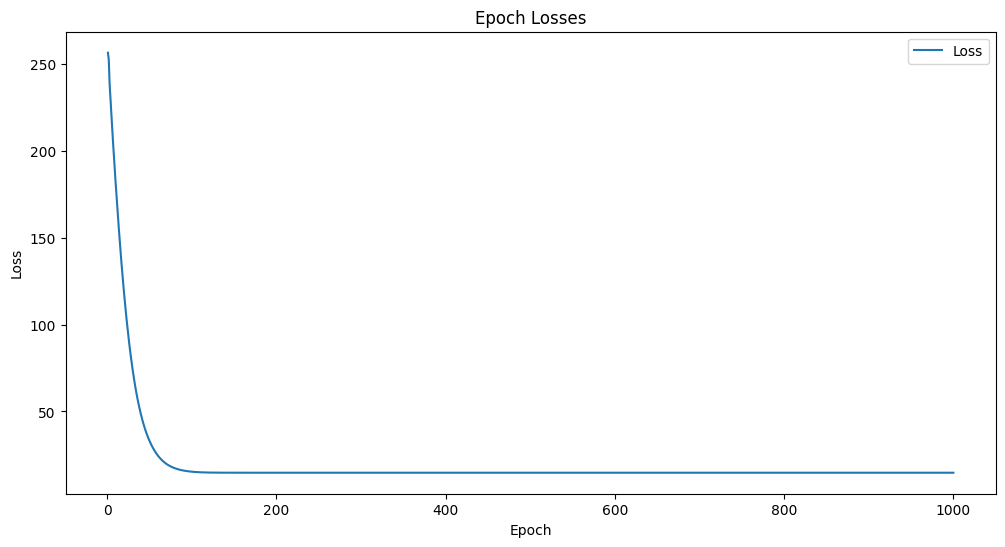

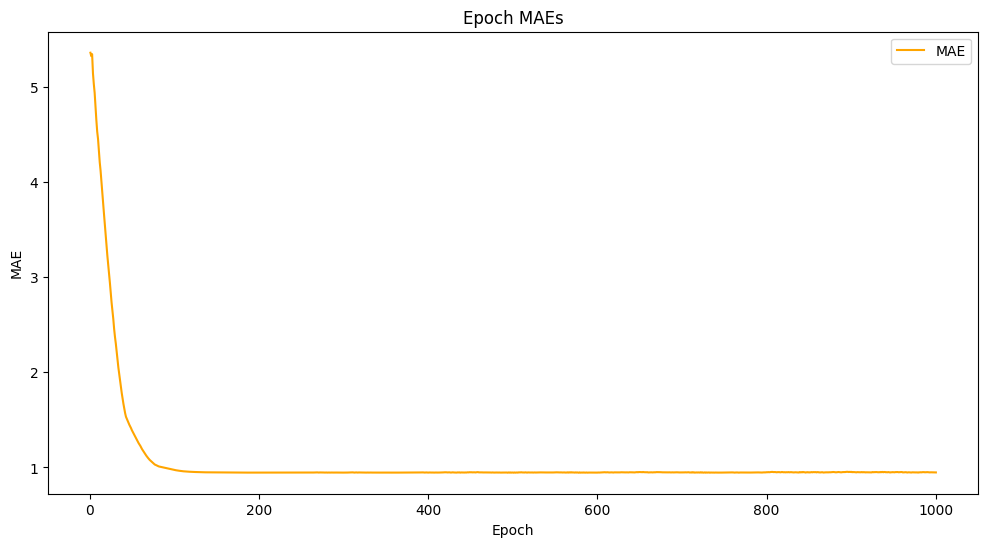

In [ ]:
import matplotlib.pyplot as plt

# Plot epoch losses
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epoch Losses')
plt.legend()
plt.show()

# Plot epoch MAEs
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(epoch_maes) + 1), epoch_maes, label='MAE', color='orange')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.title('Epoch MAEs')
plt.legend()
plt.show()